In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from pathlib import Path
import re
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Iterable

# Specifications

In [2]:
save = True
filter_zeros = True
folder = 'ERA5_norm_vae'

In [3]:
theoretic = False
backwards = False

# Functions

In [4]:
def ensure_year(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns.str.lower()
    df.columns = cols
    if "year" not in df.columns:
        for cand in ("date", "datetime", "timestamp", "time"):
            if cand in df.columns:
                s = pd.to_datetime(df[cand], errors="coerce")
                if s.notna().any():
                    df["year"] = s.dt.year
                    break
        if "year" not in df.columns:
            for col in df.columns:
                if df[col].dtype == "O":
                    s = pd.to_datetime(df[col], errors="coerce")
                    if s.notna().any():
                        df["year"] = s.dt.year
                        break
    if "year" not in df.columns:
        raise ValueError("Could not find or derive 'year' column.")
    return df

def to_cv_type(s):
    s = str(s).lower()
    if "kfold" in s or "k-fold" in s: return "KFold"
    if "block" in s:                  return "Block"
    return "Standard"

def sample_equal(series, n, seed=42):
    series = pd.Series(series).dropna()
    if len(series) == 0:
        return pd.Series(dtype=float)
    replace = len(series) < n
    return series.sample(n=n, replace=replace, random_state=seed).reset_index(drop=True)

def percentile_of_value(sim_vals, actual_val):
    sim = pd.Series(sim_vals).dropna().to_numpy()
    if sim.size == 0 or pd.isna(actual_val):
        return np.nan
    less = (sim < actual_val).sum()
    equal = (sim == actual_val).sum()
    return (less + 0.5 * equal) / sim.size * 100.0

def _event_view(df):
    out = df.copy()
    if "duration"  in out.columns:  out = out[out["duration"].notna()  & (out["duration"]  != 0)]
    if "intensity" in out.columns:  out = out[out["intensity"].notna() & (out["intensity"] != 0)]
    return out

# Data Load and Query

In [5]:
BASE = Path("/home/jovyan/signal-extraction/results") / folder
sim_pat = re.compile(fr"All_Sims_{folder}_(.+?)_ARIMA_default_(\d+)\.csv")

actual_dfs, sim_dfs = [], []

# Actuals
for f in BASE.glob(f"Standard_Summary_Exceedances_{folder}_All_ARIMA_default_*.csv"):
    df = pd.read_csv(f)
    df = ensure_year(df)
    if "location" not in df.columns:
        df["location"] = "All"
    df["source"] = "Actual"
    actual_dfs.append(df)

# Sims
for f in BASE.glob(f"All_Sims_{folder}_*_ARIMA_default_*.csv"):
    m = sim_pat.match(f.name)
    if not m:
        continue
    run_name, run_num = m.groups()
    df = pd.read_csv(f)
    df = ensure_year(df)
    df["source"] = f"{run_name}"   # e.g., contains "Standard", "Block", "KFold" cues
    sim_dfs.append(df.sort_values(["sim", "year", "storm_index"], ascending=True))

if not sim_dfs:
    raise ValueError("No simulation files found.")

sim_df    = pd.concat(sim_dfs,    ignore_index=True)
actual_df = pd.concat(actual_dfs, ignore_index=True) if actual_dfs else pd.DataFrame()

# Normalize & derive CV
sim_df.columns    = sim_df.columns.str.lower()
actual_df.columns = actual_df.columns.str.lower()
sim_df["cv_type"] = sim_df["source"].apply(to_cv_type)

has_location = "location" in actual_df.columns and "location" in sim_df.columns
yearwise_metrics  = ["frequency", "signal"]
eventwise_metrics = ["duration", "intensity"]

In [6]:
sim_df.head()

,sim,year,storm_index,unique_storm_id,signal,frequency,intensity,duration,storm_day,daily_flow,source,cv_type
0,0,2025,1,0_2025_1,0.010394,2.0,19409.034470,2,1,19409.034470,All,Standard
1,0,2025,1,0_2025_1,0.010394,2.0,19409.034470,2,2,14916.202417,All,Standard
2,0,2025,2,0_2025_2,0.010394,2.0,29895.694899,5,1,10554.086230,All,Standard
3,0,2025,2,0_2025_2,0.010394,2.0,29895.694899,5,2,24686.596546,All,Standard
4,0,2025,2,0_2025_2,0.010394,2.0,29895.694899,5,3,18458.326775,All,Standard


In [7]:
actual_df.head()

,year,signal,cluster_id,duration,intensity,frequency,location,source
0,1940,0.009543,1940.1,3,57500.0,3,All,Actual
1,1940,0.009543,1940.2,1,47400.0,3,All,Actual
2,1940,0.009543,1940.3,3,69600.0,3,All,Actual
3,1941,0.009505,1941.1,1,26900.0,1,All,Actual
4,1942,0.008626,1942.1,4,54600.0,3,All,Actual


In [8]:
actual_events = _event_view(actual_df)
sim_events    = _event_view(sim_df)

# ----------------------------------------------------
# 3) Percentiles
#    - Year-wise: one percentile per (year[,loc]) for freq/signal
#    - Event-wise: one percentile per actual event for dur/intensity
# ----------------------------------------------------
# Year-wise actual (one row per key); choose first non-null if duplicates
keys_year = ["year","location"] if has_location else ["year"]
actual_year = (actual_df
               .sort_values(keys_year)
               .groupby(keys_year, as_index=False)[yearwise_metrics]
               .first())

yearwise_rows = []
for cv in ["Standard","Block","KFold"]:
    sims_cv = sim_df[sim_df["cv_type"] == cv]
    # intersect keys
    sim_keys = sims_cv[keys_year].drop_duplicates()
    merged_keys = actual_year.merge(sim_keys, on=keys_year, how="inner")
    for _, k in merged_keys.iterrows():
        if has_location:
            pool = sims_cv[(sims_cv["year"] == k["year"]) & (sims_cv["location"] == k["location"])]
            arow = actual_year[(actual_year["year"] == k["year"]) & (actual_year["location"] == k["location"])].iloc[0]
        else:
            pool = sims_cv[sims_cv["year"] == k["year"]]
            arow = actual_year[actual_year["year"] == k["year"]].iloc[0]
        rec = {"cv_type": cv, "year": int(k["year"])}
        if has_location: rec["location"] = k["location"]
        for m in yearwise_metrics:
            rec[f"{m}_pct"] = percentile_of_value(pool[m], arow[m])
        yearwise_rows.append(rec)

yearwise_df = pd.DataFrame(yearwise_rows)

# Event-wise percentiles
eventwise_rows = []
for cv in ["Standard","Block","KFold"]:
    sims_cv_e = sim_events[sim_events["cv_type"] == cv]
    for _, arow in actual_events.iterrows():
        cond = sims_cv_e["year"].eq(arow["year"])
        if has_location:
            cond &= sims_cv_e["location"].eq(arow["location"])
        pool = sims_cv_e.loc[cond]
        if pool.empty:
            continue
        rec = {"cv_type": cv, "year": int(arow["year"])}
        if has_location: rec["location"] = arow["location"]
        if "cluster_id" in arow.index: rec["cluster_id"] = arow["cluster_id"]
        for m in eventwise_metrics:
            rec[f"{m}_pct"] = percentile_of_value(pool[m], arow.get(m, np.nan))
        eventwise_rows.append(rec)

eventwise_df = pd.DataFrame(eventwise_rows)

In [9]:
# Tidy for KDEs
yw_long = yearwise_df.melt(
    id_vars=["cv_type","year"] + (["location"] if has_location else []),
    value_vars=[f"{m}_pct" for m in yearwise_metrics],
    var_name="metric", value_name="percentile"
).assign(level_type="year")
yw_long["metric"] = yw_long["metric"].str.replace("_pct","", regex=False)

ev_id_vars = ["cv_type","year"] + (["location"] if has_location else []) + (["cluster_id"] if "cluster_id" in eventwise_df.columns else [])
ev_long = eventwise_df.melt(
    id_vars=ev_id_vars,
    value_vars=[f"{m}_pct" for m in eventwise_metrics],
    var_name="metric", value_name="percentile"
).assign(level_type="event")
ev_long["metric"] = ev_long["metric"].str.replace("_pct","", regex=False)

percentiles_long = pd.concat([yw_long, ev_long], ignore_index=True)
percentiles_long = percentiles_long[np.isfinite(percentiles_long["percentile"])]
percentiles_long = percentiles_long[percentiles_long["percentile"].between(0, 100)]

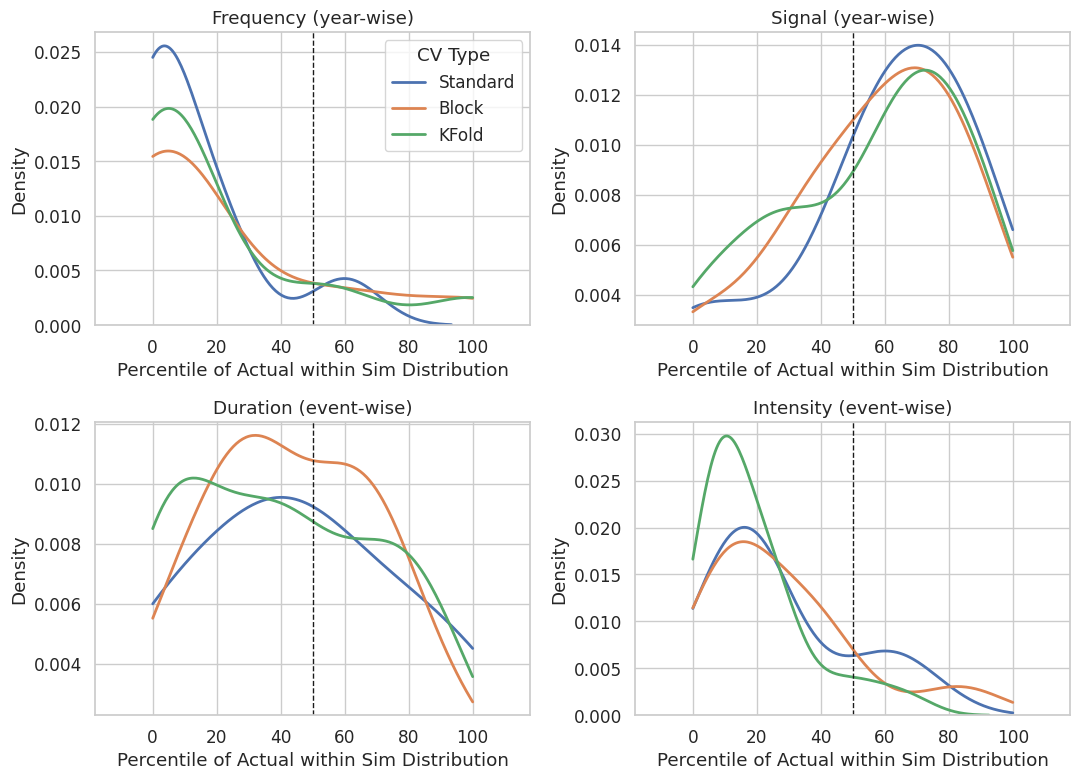

In [10]:
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.flatten()

metric_order = ["frequency", "signal", "duration", "intensity"]
title_map = {
    "frequency": "Frequency (year-wise)",
    "signal":    "Signal (year-wise)",
    "duration":  "Duration (event-wise)",
    "intensity": "Intensity (event-wise)"
}

for ax, metric in zip(axes, metric_order):
    sub = percentiles_long[percentiles_long["metric"] == metric]
    for cv in ["Standard","Block","KFold"]:
        sns.kdeplot(
            data=sub[sub["cv_type"] == cv],
            x="percentile", lw=2, clip=(0,100), common_norm=False, ax=ax, label=cv
        )
    ax.set_title(title_map.get(metric, metric.capitalize()))
    ax.set_xlim(-18, 118)
    ax.set_xlabel("Percentile of Actual within Sim Distribution")
    ax.set_ylabel("Density")
    ax.axvline(50, ls="--", lw=1, c="k")
axes[0].legend(title="CV Type")
plt.tight_layout()
plt.show()

In [11]:
rows = []
keys = ["year","location"] if has_location else ["year"]

for cv in ["Standard", "Block", "KFold"]:
    sims_cv   = sim_df[sim_df["cv_type"] == cv]          # year-wise (keep zeros)
    sims_cv_e = sim_events[sim_events["cv_type"] == cv]  # event-wise (filtered)

    # ---- YEAR-WISE (frequency, signal) ----
    merged_keys = (
        actual_year[keys]
        .merge(sims_cv[keys].drop_duplicates(), on=keys, how="inner")
        .drop_duplicates()
    )
    # Actual: one value per key
    act_year = actual_year.merge(merged_keys, on=keys, how="inner")
    # Sim: ALL sim values for those keys
    sim_year = sims_cv.merge(merged_keys, on=keys, how="inner")

    for m in yearwise_metrics:
        rows.append(pd.DataFrame({
            "cv_type": cv, "metric": m, "set": "Actual",
            "value": act_year[m].dropna().reset_index(drop=True)
        }))
        rows.append(pd.DataFrame({
            "cv_type": cv, "metric": m, "set": "Simulated",
            "value": sim_year[m].dropna().reset_index(drop=True)
        }))

    # ---- EVENT-WISE (duration, intensity) ----
    if not actual_events.empty:
        # keep only keys that exist in both actual_events and sims
        evt_keys = (
            actual_events[keys].drop_duplicates()
            .merge(sims_cv_e[keys].drop_duplicates(), on=keys, how="inner")
        )
        act_evt = actual_events.merge(evt_keys, on=keys, how="inner")
        sim_evt = sims_cv_e.merge(evt_keys, on=keys, how="inner")

        for m in eventwise_metrics:
            rows.append(pd.DataFrame({
                "cv_type": cv, "metric": m, "set": "Actual",
                "value": act_evt[m].dropna().reset_index(drop=True)
            }))
            rows.append(pd.DataFrame({
                "cv_type": cv, "metric": m, "set": "Simulated",
                "value": sim_evt[m].dropna().reset_index(drop=True)
            }))

dist_long = (
    pd.concat(rows, ignore_index=True)
    if rows else pd.DataFrame(columns=["cv_type","metric","set","value"])
).dropna(subset=["value"])

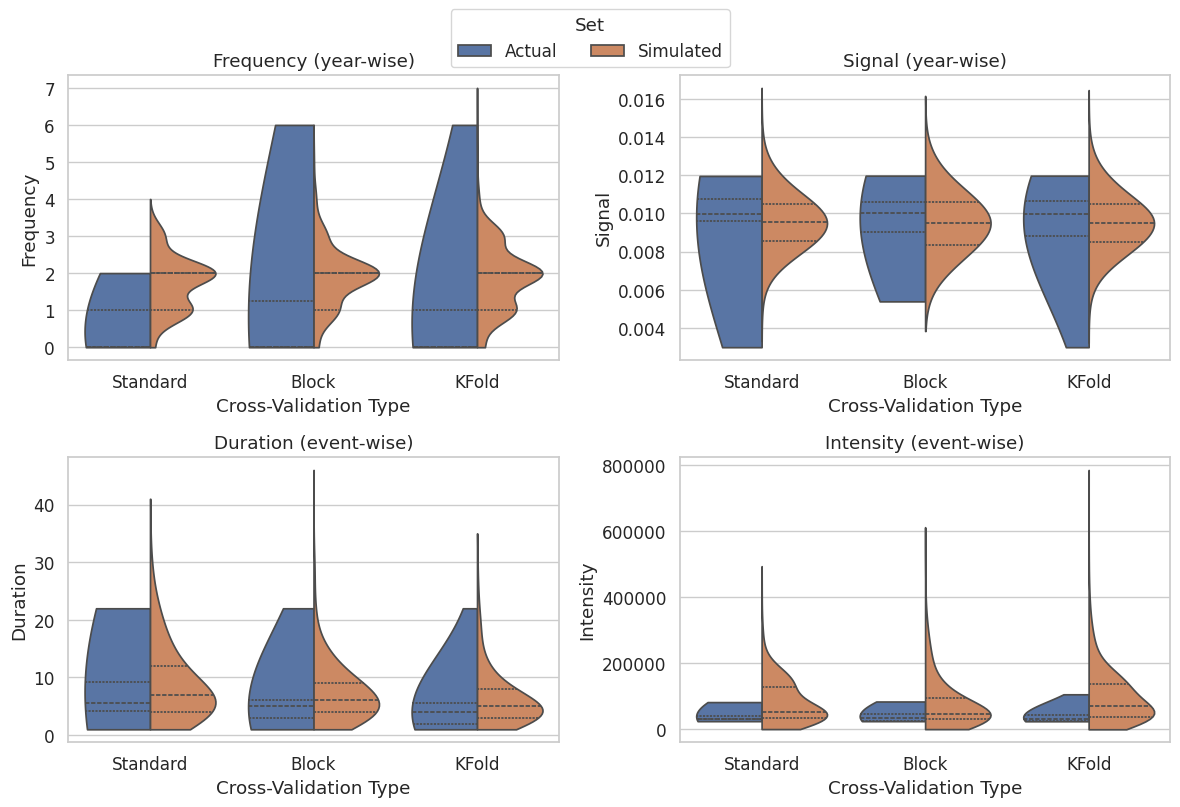

In [12]:
# Plot split violins
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(12, 8)); axes = axes.flatten()
for ax, m in zip(axes, metric_order):
    sub = dist_long[dist_long["metric"] == m]
    try:
        sns.violinplot(data=sub, x="cv_type", y="value", hue="set",
                       split=True, inner="quartile", cut=0, bw_adjust=5, density_norm='width', ax=ax)
    except TypeError:
        sns.violinplot(data=sub, x="cv_type", y="value", hue="set",
                       dodge=True, inner="quartile", cut=0, bw_adjust=5, density_norm='width', ax=ax)
    ax.set_title(title_map[m]); ax.set_xlabel("Cross-Validation Type")
    ax.set_ylabel(m.capitalize())
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes: ax.legend().remove()
fig.legend(handles, labels, title="Set", loc="upper center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.98]); plt.show()